In [ ]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Hacka')

In [ ]:
import pickle
with open('sentiment_texts.pickle', 'rb') as f:
  data = pickle.load(f)
data = data[data['SentimentScore'] != 0]

In [ ]:
with open('mentions texts.pickle', 'rb') as f:
  df = pickle.load(f)
del df['messageid']
df = df[df['DatePosted'].dt.year == 2022]
df = df.sort_values(by='DatePosted', ascending=True)

In [ ]:
df = pd.read_csv('mentions texts.csv')

In [ ]:
full_name = pd.read_excel('issuers.xlsx')

In [ ]:
def zaebalo(id):
  print(df['MessageText'][df['MessageID'].eq(id).idxmax()])
  print(df[df['MessageID'] == id].shape[0])
  print(full_name['EMITENT_FULL_NAME'].loc[df.loc[df['MessageID'] == id, 'issuerid'] - 1])

Сохраняем разметку в csv файл

Обучение

In [ ]:
train = pd.read_csv('preprocessed_data_1.csv')
train = train[train['sentiment_score'] != 0]

In [ ]:
train

,issuerid,sentiment_score,message_text
0,100,2.0,США вводят санкции против российских банков М...
1,24,2.0,company_name БУДЕТ ОСПАРИВАТЬ РЕШЕНИЕ ПОЛЬШИ...
2,4,4.0,company_name может выплатить дивиденды по ит...
3,4,2.0,company_name попросила клиентов не оплачиват...
4,236,4.0,Алекперов один был готов заплатить за долю в c...
...,...,...,...
8942,99,4.0,Взгляд на компанию company_name эффект от от...
8943,99,5.0,Взгляд на компанию company_name 3й кв 2023 г ...
8944,99,4.0,company_name акции с потенциалом роста свыше...
8945,99,4.0,company_name анализ ключевых тем Взгляд БКС ...


In [ ]:
!pip install CatBoost -q

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Разделение данных на обучающий и тестовый наборы
X = train['message_text']
y = train['sentiment_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Преобразование в Pool потому что catboost быстрее с ним работает
train_Pool = Pool(
    data=pd.DataFrame(data=X_train),
    label=y_train,
    text_features=['message_text']
)
test_Pool = Pool(
    data=pd.DataFrame(data=X_test),
    label=y_test,
    text_features=['message_text']
)

# Обучение модели CatBoost
model = CatBoostClassifier(
        task_type='GPU',
        iterations=3700,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=1500,
        border_count = 14,
        l2_leaf_reg=5.564,
        thread_count=13,
        depth = 5.0,
        learning_rate=0.1)

model.fit(train_Pool, eval_set=(test_Pool), verbose=100)
# Предсказание на тестовом наборе
y_pred = model.predict(test_Pool)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

0:	learn: 0.6010517	test: 0.6318182	best: 0.6318182 (0)	total: 18.6ms	remaining: 1m 8s
100:	learn: 0.6269187	test: 0.6409091	best: 0.6431818 (73)	total: 1.13s	remaining: 40.3s
200:	learn: 0.6482376	test: 0.6443182	best: 0.6448864 (195)	total: 2.09s	remaining: 36.3s
300:	learn: 0.6678511	test: 0.6454545	best: 0.6477273 (216)	total: 3.05s	remaining: 34.5s
400:	learn: 0.6834849	test: 0.6460227	best: 0.6482955 (389)	total: 4.04s	remaining: 33.2s
500:	learn: 0.6978397	test: 0.6454545	best: 0.6500000 (477)	total: 4.99s	remaining: 31.9s
600:	learn: 0.7164582	test: 0.6426136	best: 0.6500000 (477)	total: 5.92s	remaining: 30.5s
700:	learn: 0.7309551	test: 0.6386364	best: 0.6500000 (477)	total: 6.87s	remaining: 29.4s
800:	learn: 0.7427516	test: 0.6443182	best: 0.6500000 (477)	total: 7.81s	remaining: 28.3s
900:	learn: 0.7511370	test: 0.6431818	best: 0.6500000 (477)	total: 8.76s	remaining: 27.2s
1000:	learn: 0.7605173	test: 0.6465909	best: 0.6500000 (477)	total: 12.5s	remaining: 33.6s
1100:	learn: 

In [ ]:
model.save_model('trained_model.cbm')

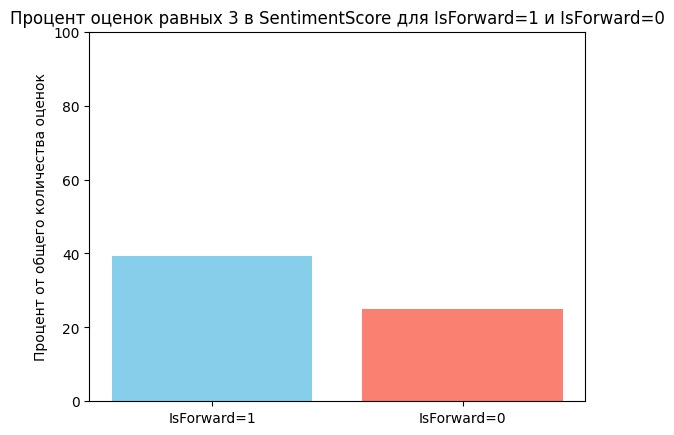

In [ ]:
percentages = data.groupby('IsForward')['SentimentScore'].apply(lambda x: (x == 3).sum() / len(x) * 100)

# Создание графика
plt.bar(['IsForward=1', 'IsForward=0'], percentages, color=['skyblue', 'salmon'])

# Добавление заголовка и меток осей
plt.title('Процент оценок равных 3 в SentimentScore для IsForward=1 и IsForward=0')
plt.ylabel('Процент от общего количества оценок')
plt.ylim(0, 100)  # Установка пределов оси y от 0 до 100
plt.show()


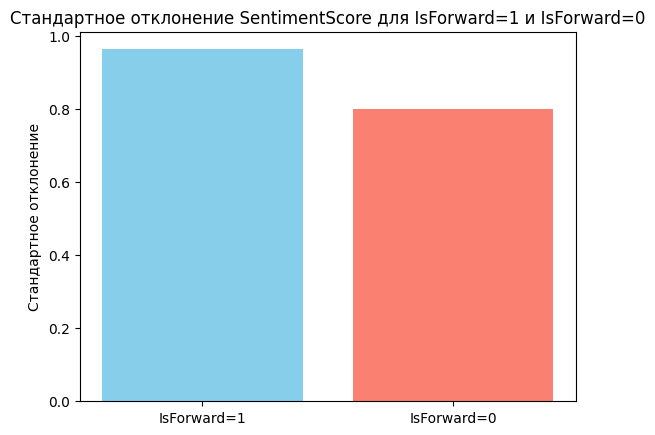

In [ ]:
std_forward = data.loc[data['IsForward'] == 1, 'SentimentScore'].std()
std_not_forward = data.loc[data['IsForward'] == 0, 'SentimentScore'].std()

# Создание графика
plt.bar(['IsForward=1', 'IsForward=0'], [std_forward, std_not_forward], color=['skyblue', 'salmon'])

# Добавление заголовка и меток осей
plt.title('Стандартное отклонение SentimentScore для IsForward=1 и IsForward=0')
plt.ylabel('Стандартное отклонение')
plt.show()

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope

def objective(params):
    model = CatBoostClassifier(**params, task_type='GPU')

    model.fit(train_Pool, eval_set=(test_Pool), verbose=100)

    y_pred = model.predict(test_Pool)
    accuracy = accuracy_score(y_test, y_pred)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Пространство поиска всех гиперпараметров
space = {
    'depth': hp.quniform('depth', 1, 6, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -3, 3),
    'iterations': hp.quniform('iterations', 100, 5000, 100),
    'border_count': hp.quniform('border_count', 1, 255, 1),
    'thread_count': hp.quniform('thread_count', 1, 16, 1),
}


# Запуск оптимизации гиперпараметров
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

print(best)

0:	learn: 1.3784377	test: 1.3613993	best: 1.3613993 (0)	total: 11.2ms	remaining: 16.8s

100:	learn: 0.8665569	test: 0.8885359	best: 0.8876425 (95)	total: 716ms	remaining: 9.91s

200:	learn: 0.7883861	test: 0.8824744	best: 0.8813051 (190)	total: 1.34s	remaining: 8.64s

300:	learn: 0.7327156	test: 0.8839187	best: 0.8812066 (209)	total: 1.94s	remaining: 7.71s

400:	learn: 0.6870540	test: 0.8824205	best: 0.8812066 (209)	total: 2.58s	remaining: 7.09s

500:	learn: 0.6496507	test: 0.8852584	best: 0.8811274 (424)	total: 5.46s	remaining: 10.9s

600:	learn: 0.6148874	test: 0.8809534	best: 0.8809534 (600)	total: 6.52s	remaining: 9.76s

700:	learn: 0.5849099	test: 0.8824886	best: 0.8807913 (602)	total: 7.17s	remaining: 8.17s

800:	learn: 0.5585410	test: 0.8847173	best: 0.8807913 (602)	total: 7.79s	remaining: 6.8s

900:	learn: 0.5338324	test: 0.8849511	best: 0.8807913 (602)	total: 8.41s	remaining: 5.59s

1000:	learn: 0.5111824	test: 0.8875755	best: 0.8807913 (602)	total: 9.05s	remaining: 4.51s

110

НОВОСТЬ О НАЛОГЕ WINDFALLTAX ИМЕЕТ РЕЙТИНГ == 2
НОВОСТЬ О ПАДЕНИИ ЧИСТОЙ ПРИБЫЛИ НА 65% == 1
НОВОСТЬ РУБЛЬ + ПАДЕНИЕ НА 20% == 1
НОВОСТЬ IMOEX == SHORT SILVER + GOLD == LONG РЕЙТИНГ == 1
НОВОСТЬ О ЗАСЕДАНИИ ПРИ НЕЗНАЧИТЕЛЬНОМ РОСТЕ == 4

In [ ]:
data['IsForward'] = data['IsForward'].astype(int)

In [ ]:
data

,MessageID,ChannelID,issuerid,SentimentScore,DateAdded,DatePosted,MessageText,IsForward
0,241407,1203560567,153,2,2023-05-12 19:03:20,2023-05-12 19:02:42,⚠️🇷🇺#SELG #дивиденд сд Селигдар: дивиденды 20...,False
1,33684,1136626166,230,4,2023-02-03 20:56:29,2023-02-03 16:46:34,Ozon продолжает развивать специализированные ф...,False
2,10090,1063908560,118,4,2023-06-02 19:18:37,2023-06-02 18:50:00,​Фокусы продолжаются🔥Акции и инвестиции 📈ВТБ ...,False
3,10090,1063908560,220,5,2023-06-02 19:18:37,2023-06-02 18:50:00,​Фокусы продолжаются🔥Акции и инвестиции 📈ВТБ ...,False
4,9826,1063908560,89,2,2023-04-24 17:51:38,2023-04-24 13:54:00,​​Windfall Tax — налог на сверхприбыль. Какие ...,False
...,...,...,...,...,...,...,...,...
9284,47482,1197210433,157,4,2023-03-20 14:53:14,2023-03-20 12:15:21,#FLOT #Дивиденды 💰 7% — возможная дивдоходност...,False
9285,233829,1203560567,157,4,2023-03-20 14:58:04,2023-03-20 12:05:49,🇷🇺#FLOT #отчетность ЧИСТАЯ ПРИБЫЛЬ СОВКОМФЛОТ...,False
9286,9789,1063908560,225,3,2023-04-19 17:51:56,2023-04-19 15:32:00,​​Ключевой принцип создания портфеля 🔹Диверси...,False
9287,233867,1203560567,127,3,2023-03-20 14:58:04,2023-03-20 14:33:32,"""💥🇷🇺#PLZL #листинг #торги """"Полюс"""" ведет диа...",False


In [ ]:
gay = data[data['MessageText'].str.contains('аномаль', case=False)]

In [ ]:
print(data['MessageText'][data['MessageID'].eq(45742).idxmax()])

У $PLZL все также проходят аномальные покупки, которые замечает Шпион РЦБ  В целом спекулятивно есть шансы на откат в сторону 8520-8360, но среднесрочно это рост к уровням 9500-10000.  Большую часть позиции продать стоит, но так как объемы на покупку проходят, то можно будет докупать на 8360 и ниже! Не думаю, что в ближайшее время укатят на 8000 и ниже!


In [ ]:
score = pd.read_csv('sentiment.csv')
del score['Unnamed: 0']
score

,MessageID,ChannelID,issuerid,SentimentScore
0,241407,1203560567,153,2
1,33684,1136626166,230,4
2,10090,1063908560,118,4
3,9826,1063908560,89,2
4,9672,1063908560,160,2
...,...,...,...,...
10926,9789,1063908560,225,3
10927,4789,1239405989,127,3
10928,233867,1203560567,127,3
10929,3681,1219484576,127,3


In [ ]:
data[(data['DatePosted'] <= '2023-02-01') & (data['SentimentScore'] <= 2)]

,MessageID,ChannelID,issuerid,SentimentScore,DateAdded,DatePosted,MessageText,IsForward
1293,226422,1203560567,53,2,2023-01-24 21:00:01,2023-01-24 15:38:48,🇷🇺#GMKN Норникель из-за проблем с комплектующ...,0
1305,225966,1203560567,223,2,2023-01-20 15:01:22,2023-01-20 09:34:05,⚠️🇷🇺#соцсети #россия #YNDX #VKCO Социальные се...,0
1312,226393,1203560567,236,2,2023-01-24 15:00:48,2023-01-24 14:15:46,"""⚠️🇷🇺#YNDX в Молдавии проверят """"Яндекс.Такси...",0
1346,226715,1203560567,32,2,2023-01-26 15:01:25,2023-01-26 11:32:07,🇷🇺#AFLT #отчетность ГРУППА АЭРОФЛОТ СОКРАТИЛА...,0
2313,9246,1063908560,4,2,2023-01-26 20:55:07,2023-01-26 17:01:37,​​Поалросили и бросили? Потускнели ли алмазы Р...,0
...,...,...,...,...,...,...,...,...
8714,12638,1001029560,235,0,2022-12-26 14:37:23,2022-12-26 13:53:40,❓ На чем можно заработать в последнюю неделю г...,0
8915,227436,1203560567,7,2,2023-01-31 20:59:51,2023-01-31 17:29:38,⚠️🇷🇺#VTBR #дивиденд #прогноз Frank Media: ВТБ...,0
9185,6678,1215658351,230,0,2023-01-19 21:02:06,2023-01-19 18:07:36,Мосбиржа в моменте Индекс МосБиржи в ходе сег...,0
9214,225762,1203560567,4,2,2023-01-19 15:01:45,2023-01-19 09:47:27,⚠️💎#алмазы #прогноз Аналитики прогнозируют сн...,0


In [ ]:
data[(data['DateAdded'] >= '2023-05-01') & (data['SentimentScore'] >= 3)]

,MessageID,ChannelID,issuerid,SentimentScore,DateAdded,DatePosted,MessageText,IsForward
2,10090,1063908560,118,4,2023-06-02 19:18:37,2023-06-02 18:50:00,​Фокусы продолжаются🔥Акции и инвестиции 📈ВТБ ...,0
3,10090,1063908560,220,5,2023-06-02 19:18:37,2023-06-02 18:50:00,​Фокусы продолжаются🔥Акции и инвестиции 📈ВТБ ...,0
30,239758,1203560567,103,3,2023-05-01 19:03:46,2023-05-01 08:52:26,🗓КАЛЕНДАРЬ НА СЕГОДНЯ — 2023.05.01 📌ТОРГИ Гер...,0
67,3769,1172556372,103,4,2023-06-23 19:21:23,2023-06-23 13:40:47,"""Московская биржа 29 июня начнет торги на сроч...",0
314,3542,1160971567,225,3,2023-09-09 13:20:10,2023-09-09 11:25:01,"""📋Итоги недели 🇷🇺🏦Росстат подтвердил предвари...",0
...,...,...,...,...,...,...,...,...
9264,6262,1480181440,111,4,2023-08-30 19:43:09,2023-08-30 17:24:33,🛢 Лукойл: как долго продлится туземун? С прош...,0
9273,255289,1203560567,111,4,2023-08-30 19:24:47,2023-08-30 16:17:43,❗️🇷🇺#LKOH #buyback ВЛАСТИ РФ РАССМАТРИВАЮТ ОБР...,0
9278,243244,1203560567,103,4,2023-05-25 19:07:02,2023-05-25 18:24:14,"""🌕🇷🇺#бонды #золото #россия Эмитенты готовят н...",0
9279,3724,1172556372,103,4,2023-06-05 19:23:10,2023-06-05 16:56:58,"Мосбиржа В мае число физических лиц, имеющих ...",0


Графики

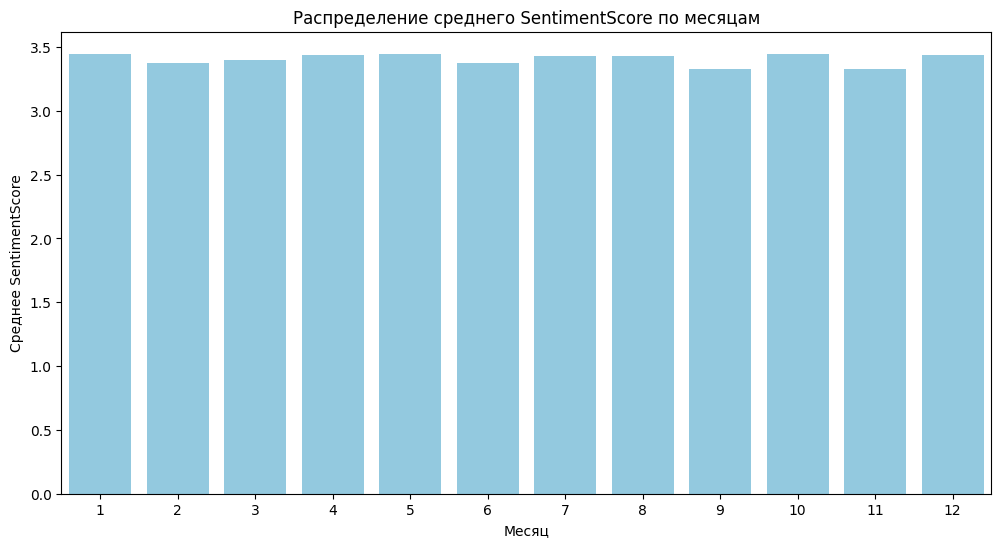

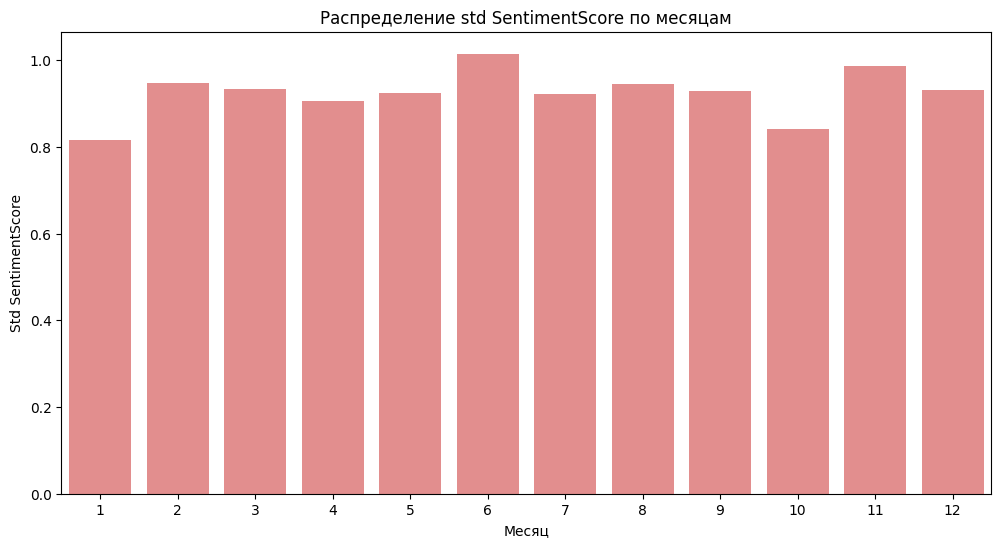

In [ ]:
data['DatePosted'] = pd.to_datetime(df['DatePosted'])
data['Month'] = data['DatePosted'].dt.month

# Группировка данных по месяцу и вычисление среднего и std SentimentScore
grouped = data.groupby('Month')['SentimentScore'].agg(['mean', 'std']).reset_index()

# Построение графика среднего SentimentScore по месяцам
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='mean', data=grouped, color='skyblue')
plt.xlabel('Месяц')
plt.ylabel('Среднее SentimentScore')
plt.title('Распределение среднего SentimentScore по месяцам')

# Построение графика std SentimentScore по месяцам
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='std', data=grouped, color='lightcoral')
plt.xlabel('Месяц')
plt.ylabel('Std SentimentScore')
plt.title('Распределение std SentimentScore по месяцам')

plt.show()